## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on mock P1D data from a given model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.emulator import gp_emulator
from cup1d.data import data_Chabanier2019
from cup1d.data import data_Karacayli2022
from cup1d.data import data_QMLE_Ohio
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Decide number of IGM free parameters (need to set this before creating theory)

In [2]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=2
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

### Setup real P1D measurement we are trying to mock

This will be use to get the list of redshifts, wavenumbers and covariances

In [3]:
# setup data to mimic, with a maximum z to avoid redshifts not emulated
data=data_Chabanier2019.P1D_Chabanier2019(zmin=2.0,zmax=4.5)
#data=data_QMLE_Ohio.P1D_QMLE_Ohio(zmin=2.0,zmax=4.5)
print(data.z)

[2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4]


In [4]:
# option to add extra P1D (high-resolution)
if True:
    extra_data=data_Karacayli2022.P1D_Karacayli2022(zmin=2.0,zmax=4.5)
else:
    extra_data=None

Nz = 15 , Nk = 21


### Setup emulator and theory

The emulator will be used both to make a mock, and in the likelihood 

In [5]:
basedir="/lace/emulator/sim_suites/Australia20/"
emu=gp_emulator.GPEmulator(basedir=basedir,emu_type="polyfit",kmax_Mpc=8,
                           asymmetric_kernel=True,rbf_only=True,
                           drop_tau_rescalings=True,train=True)
theory=lya_theory.Theory(zs=data.z,emulator=emu,free_param_names=free_param_names)

 /global/homes/f/font/.conda/envs/cup1d/lib/python3.9/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.45 seconds


In [6]:
# print parameter values used to create mock data
for p in theory.get_parameters():
    print(p.info_str(all_info=True))

ombh2 = 0.022 , 0.018 , 0.026
omch2 = 0.12 , 0.1 , 0.14
As = 2.1e-09 , 1e-09 , 3.2e-09
ns = 0.965 , 0.88 , 1.05
mnu = 0.0 , 0.0 , 1.0
nrun = 0.0 , -0.8 , 0.8
H0 = 67.0 , 50 , 100
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_kF_1 = 0.0 , -0.4 , 0.4


### Create mock P1D data

Use Lya theory to mimic mock data

In [7]:
mock=mock_data.Mock_P1D(data=data,theory=theory)

In [8]:
# check if we also need mock extra_p1d
if extra_data:
    extra_theory=lya_theory.Theory(zs=extra_data.z,emulator=emu,
                                   free_param_names=free_param_names)
    extra_mock=mock_data.Mock_P1D(data=extra_data,theory=extra_theory)
else:
    extra_mock=None

### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [9]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=mock,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_mock)

As = 2.0999999999999998e-09 , 1e-09 , 3.2e-09
ns = 0.9650000000000001 , 0.88 , 1.05
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_1 = 0.0 , -0.4 , 0.4
chi2 = -0.0


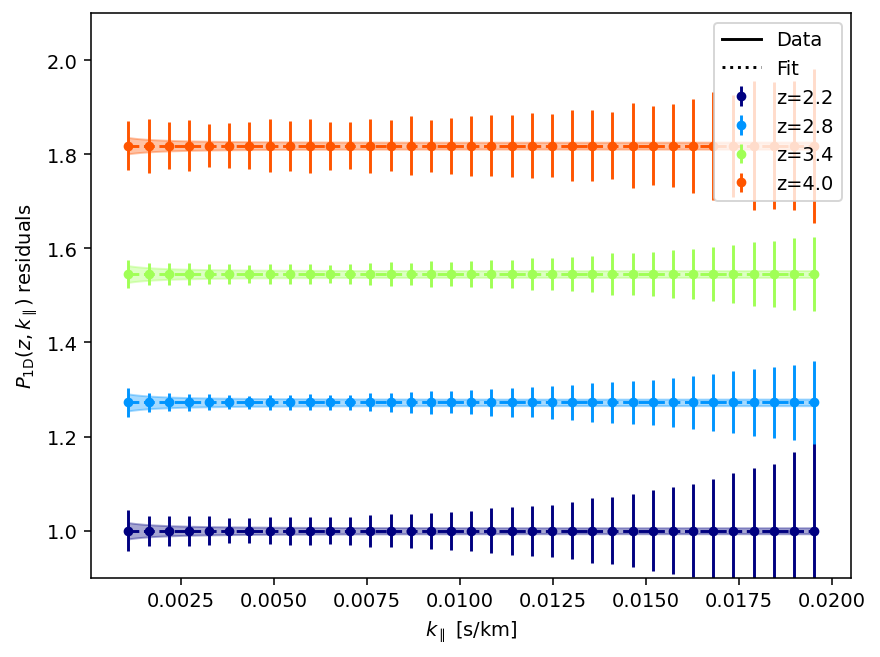

In [10]:
# check starting point for free parameters (should be equal to truth)
test_values=len(free_param_names)*[0.5]
for p in like.parameters_from_sampling_point(values=test_values):
    print(p.info_str(all_info=True))
print('chi2 =',like.get_chi2(values=test_values))
like.plot_p1d(values=test_values,residuals=True,plot_every_iz=3)

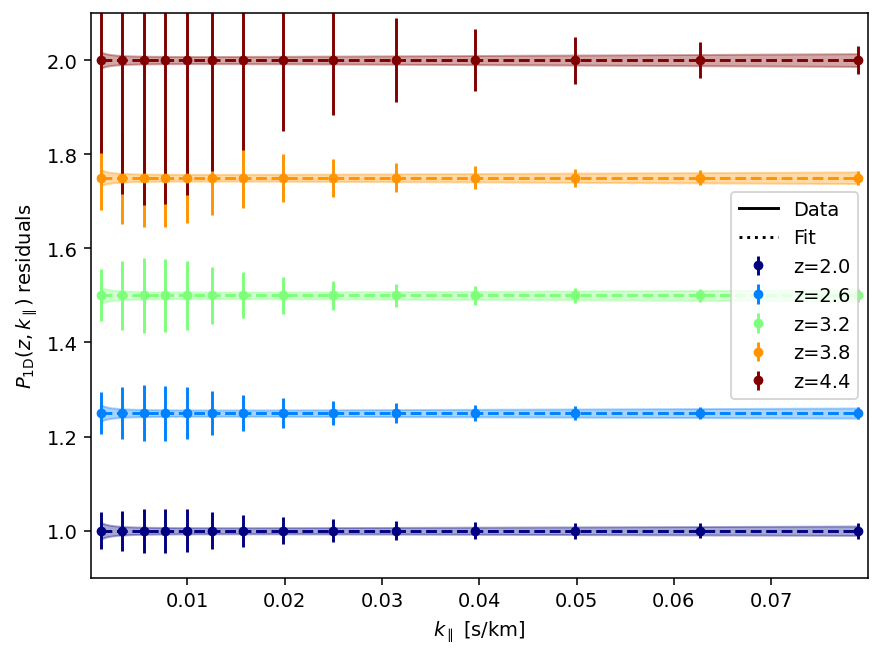

In [11]:
if extra_mock:
    like.extra_p1d_like.plot_p1d(residuals=True,plot_every_iz=3)

### Run iminuit minimizer

In [12]:
# choose starting point for free parameters (within 0.5 +/- ini_sigma, in the unit cube)
ini_sigma=0.1
ini_values=2*ini_sigma*np.random.random(len(like.free_params))+0.5-ini_sigma
print('ini values',ini_values)
for p in like.parameters_from_sampling_point(values=ini_values):
    print(p.info_str(all_info=True))

ini values [0.44884285 0.44776493 0.58852247 0.45011748 0.47234582 0.48164123
 0.41243786 0.422886   0.49766841 0.59371758]
As = 1.98745427859674e-09 , 1e-09 , 3.2e-09
ns = 0.9561200380684735 , 0.88 , 1.05
ln_tau_0 = 0.01770449344467831 , -0.1 , 0.1
ln_sigT_kms_0 = -0.03990601268280819 , -0.4 , 0.4
ln_gamma_0 = -0.011061672871245154 , -0.2 , 0.2
ln_kF_0 = -0.0073435073560626785 , -0.2 , 0.2
ln_tau_1 = -0.03502485789183457 , -0.2 , 0.2
ln_sigT_kms_1 = -0.06169119780860183 , -0.4 , 0.4
ln_gamma_1 = -0.0018652756451672525 , -0.4 , 0.4
ln_kF_1 = 0.07497406354317271 , -0.4 , 0.4


In [13]:
minimizer = iminuit_minimizer.IminuitMinimizer(like,ini_values=ini_values)

In [14]:
minimizer.minimize(compute_hesse=True)

In [15]:
# what is the chi2 of the best-fit? (should be close to 0)
best_fit_values=np.array(minimizer.minimizer.values)
like.get_chi2(values=best_fit_values)

2.9852513210813177e-06

In [16]:
# what was the chi2 of the starting point?
like.get_chi2(values=ini_values)

48.73793920068002

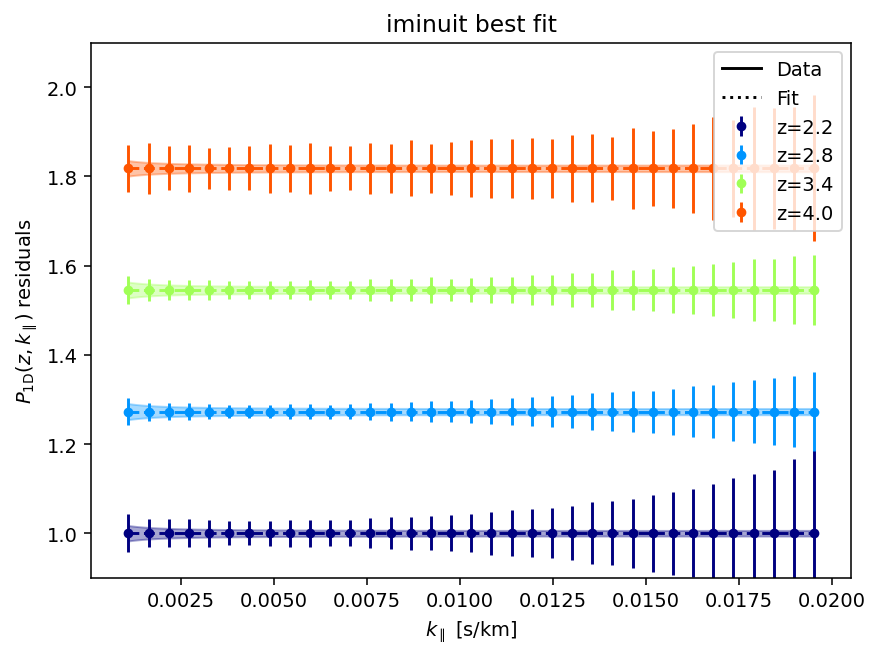

In [17]:
minimizer.plot_best_fit(plot_every_iz=3)

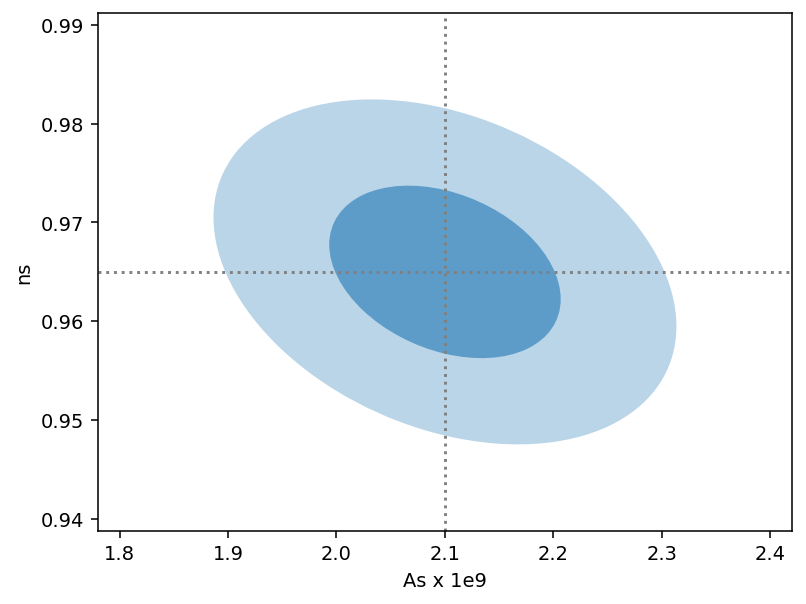

In [18]:
minimizer.plot_ellipses('As','ns')

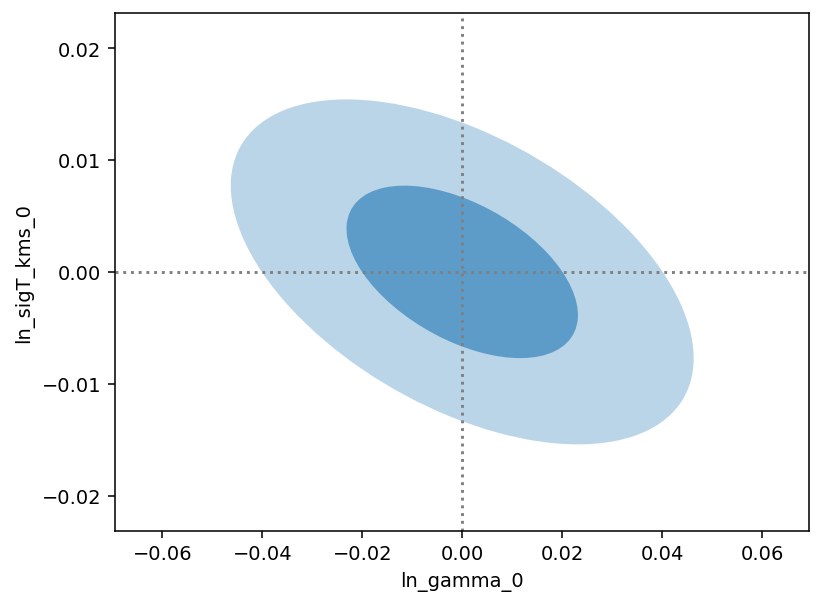

In [19]:
minimizer.plot_ellipses('ln_gamma_0','ln_sigT_kms_0')

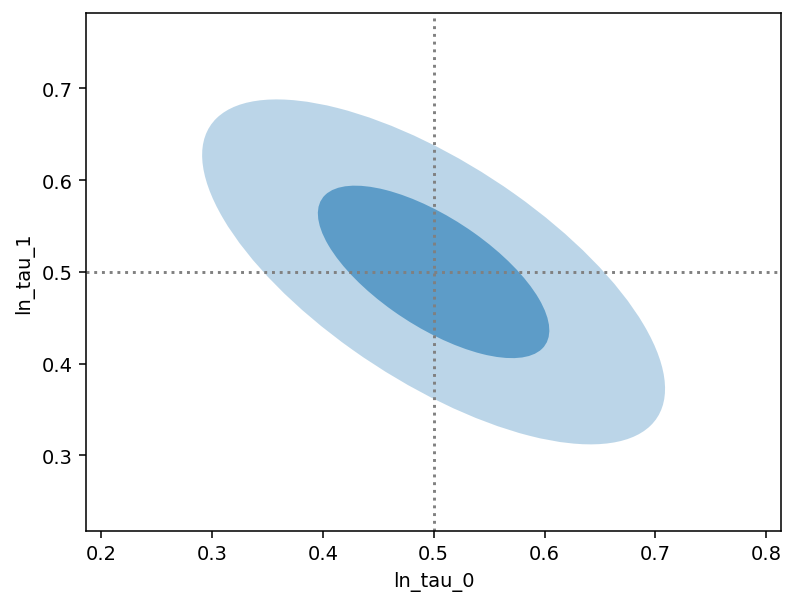

In [20]:
minimizer.plot_ellipses('ln_tau_0','ln_tau_1',cube_values=True)

In [21]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 51.26                      │              Nfcn = 791              │
│ EDM = 2.9e-11 (Goal: 0.0001)     │           time = 21.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.50    │   0.05    │            │            │         │         │       │
│ 1 │ x1   │   0.50    │   0.05    │            │            │         │         │       │
│ 2 │ x2   │    0.5    │    0.1    │            │            │         │         │       │
│ 3 │ x3   │   0.50    │   0.01    │            │            │         │         │       │
│ 4 │ x4   │   0.50    │   0.06    │            │            │         │         │       │
│ 5 │ x5   │   0.50    │   0.12    │            │            │         │         │       │
│ 6 │ x6   │   0.50    │   0.09    │            │            │         │         │       │
│ 7 │ x7   │   0.50    │   0.06    │            │            │         │         │       │
│ 8 │ x8   │   0.50    │   0.07    │            │            │         │         │       │
│ 9 │ x9   │   0.50    │   0.12    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │   0.00235 -0.000784  -0.00481 -9.55e-05    -0.002    0.0049   0.00297   0.00116 -0.000321  -0.00278 │
│ x1 │ -0.000784   0.00264   0.00115  -8.5e-05   0.00109  -0.00367    -0.001  -0.00147   0.00185 -0.000912 │
│ x2 │  -0.00481   0.00115    0.0109 -2.08e-05   0.00517   -0.0099  -0.00664  -0.00171  0.000551   0.00509 │
│ x3 │ -9.55e-05  -8.5e-05 -2.08e-05  9.29e-05 -0.000279  -0.00015  2.97e-05 -0.000196 -0.000111  0.000672 │
│ x4 │    -0.002   0.00109   0.00517 -0.000279   0.00335  -0.00441  -0.00338 -0.000246  0.000775   0.00049 │
│ x5 │    0.0049  -0.00367   -0.0099  -0.00015  -0.00441    0.0139   0.00503   0.00512  -0.00346  -0.00481 │
│ x6 │   0.00297    -0.001  -0.00664  2.97e-05  -0.00338   0.00503   0.00883    -0.001   0.00285  -0.00725 │
│ x7 │   0.00116  -0.00147  -0.00171 -0.000196 -0.000246   0.00512    -0.001   0.00397   -0.0031 -0.000534 │
│ x8 │ -0.000321   0.00185  0.000551 -0.000111  0.000775  -0.00346   0.00285   -0.0031   0.00453  -0.00372 │
│ x9 │  -0.00278 -0.000912   0.00509  0.000672   0.00049  -0.00481  -0.00725 -0.000534  -0.00372    0.0149 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [22]:
minimizer.minimizer.errors

<ErrorView x0=0.048490499925659285 x1=0.05133540048449009 x2=0.10433954731000228 x3=0.009638764507318 x4=0.057895854409769014 x5=0.11809617258794676 x6=0.09395681028452295 x7=0.06300453866780904 x8=0.06732022479753218 x9=0.12213953448491097>

In [23]:
minimizer.best_fit_value('ln_tau_0',return_hesse=True)

(1.2803586954546198e-07, 0.020867909462000456)